## Result Discussion

This analysis describes the pipes and filters pattern, where two separate pipelines are defined: one for freemium users and one for premium users. The pattern thus looks as follows:

`T1a -> T2a -> T3a`

`T2b -> T2b -> T3b`

Here T3a is synonymous to t3 in the paper, and T3b to t4.

For each of the services, we defined the following processing efforts.

| Service | Processing time (ms) |
| ------- | -------------------- |
| T1a     | 12                   |
| T2a     | 15                   |
| T3a     | 11                   |
| T1b     | 8                    |
| T2b     | 9                    |
| T3b     | 10                   |

Here, it should stand out that `T2a` is the slowest task for the freemium users and `T3b` for the premium users. Intuitively, these are the bottlenecking services in these pipelines as it is as pipelines are as fast as it's slowest component.

### Some experimental observations

- `T2a` and `T3b` bottleneck naturally as their processing time is the highest.
  - This is consistent in the experimental data.
- Up until $f=0.6$ (where $f$ is the ratio of freemium requests), the freemium behaviour is consistent with the theoretical model, however, afterwards, the utilization declines somehow.
  - This decline is complemented by the premium pipeline which suddenly goes up.
- The premium pipeline doesn't have the smooth logarithmic curve the theoretical model has, but instead declines quickly in $f \in [0, 0.6]$.
- None of the services is every fully saturated.
  - The maximum utilization is $70\%$.
- None of the experimental behaviours correlates with the theoretical behaviours according to Spearman's $r$.
  - This is likely in part due to the small sample size.

#### Average errors

- When comparing the normalized and absolute delay data, there is a noticeable difference.

  - Somewhere between $\pm 20ms$ and $\pm 170ms$ difference in measured delays.
  - This propagates itself in the measured mean average errors.
    - For the non-normalized data the MAE is $\pm 110ms$ and normalized data is $\pm 15\%$.
  - The theoretical results are still noticably off when calculating the mean average percentage error.
    - Non-normalized data deviates $\pm 21\%$ and normalized data $\pm 11\%$.

- A noticable difference exists between the experimental and theoretical CPU utilization data.
  - The absolute errors in non-normalized data lie between $\pm 30\%$ and $\pm 45\%$, and effect that is amplified in the MAPE scores which lie between $\pm 85\%$ and $\pm 165\%$.
  - This error is NOT resolved by normalizing the data, as MAPE scores still lie between $\pm 18\%$ and $\pm 35\%$, and MAE scores that lie between $\pm 25\%$ and $\pm 40\%$.

# Overview

This notebook implements an early evaluation of the strength of the theoretical gateway aggregator model using experimental results.
Compares single experimental setups with the Pinciroli's (2023) theoretical results to generate an intuition of their relationship.


It visualizes the results, calculates the _mean average (percentage) error_ between the results, suggesting how 'off' the results are.
It also calculates Pearson's $r$ to understand the correlation between results.


In [25]:
import datetime
import json
import os
import typing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import gssi_experiment.util.notebook_helper as nb_helper
import gssi_experiment.util.stat_helper as stat_helper
import gssi_experiment.util.util as util
import gssi_experiment.util.prometheus_raw_data_helper as prom_raw_data_helper

pincirollis_data_path = "/workspaces/muBench-experiment/gssi_experiment/pipes_and_filters/pipes_and_filters_separated/Core1_N50.csv"
synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

base_path = "/workspaces/muBench-experiment/gssi_experiment/pipes_and_filters/pipes_and_filters_separated/results/pinciroli_replication_1/"

intensity_key = "freemium_intensity"

## Dataframe creation

In [26]:
TIME_FORMAT = "%Y-%m-%dT%H:%M:%S.000Z"
TIMEFORMAT_2 = "%Y-%m-%d %H:%M:%S"

service_cols = ["s1a", "s2a", "s1b", "s2b", "s3", "s4"]


def get_data_points() -> typing.Iterator:
    for experiment_folder in util.iterate_through_nested_folders(
        base_path, max_depth=2
    ):
        # Calculates delay data
        mubench_file = f"{experiment_folder}/mubench_results.csv"
        exp_df = pd.read_csv(mubench_file, header=0)
        avg_latency = np.average(exp_df["latency_ms"])

        # Reads metadata to calculate intensity
        meta_path = f"{experiment_folder}/metadata.json"
        with open(meta_path, "r", encoding="utf-8") as meta_file:
            metadata = json.loads(meta_file.read())
        cpu_limit = metadata["cmd_arguments"]["cpu_limit"]
        replicas = metadata["cmd_arguments"]["replicas"]
        max_steps = metadata["cmd_arguments"]["simulation_steps"]
        # HACK: add this to the metadata.
        step = int(os.path.basename(experiment_folder).split("_")[0])
        intensity = step / max_steps

        # Calculates CPU utilization data.
        start_time = datetime.datetime.strptime(metadata["start_time"], TIME_FORMAT)
        end_time = datetime.datetime.strptime(metadata["end_time"], TIME_FORMAT)
        utilization_data = prom_raw_data_helper.calculate_average_cpu_time(
            experiment_folder, service_cols, start_time, end_time
        )

        data_point = [
            step,
            max_steps,
            intensity,
            avg_latency,
            cpu_limit,
            replicas,
            metadata["start_time"],
            metadata["end_time"],
            *utilization_data,
        ]
        yield data_point


cols = [
    "step",
    "max_step",
    intensity_key,
    "avg_latency_ms",
    "cpu_limit",
    "replicas",
    "experiment_start_time",
    "experiment_end_time",
]
cpu_util_format = "cpu_utilization_{service}"
cpu_columns = [cpu_util_format.format(service=service) for service in service_cols]
cols.extend(cpu_columns)

data_points = get_data_points()

df = pd.DataFrame(data_points, columns=cols)

old_df_len = len(df)
df = df.dropna()
new_df_len = len(df)
if new_df_len != old_df_len:
    print("!!!SOME ROWS WERE REMOVED BECAUSE THEY ARE NAN!!!")
    print(f"The row count was {old_df_len} and now is {new_df_len}.")

df

,step,max_step,freemium_intensity,avg_latency_ms,cpu_limit,replicas,experiment_start_time,experiment_end_time,cpu_utilization_s1a,cpu_utilization_s2a,cpu_utilization_s1b,cpu_utilization_s2b,cpu_utilization_s3,cpu_utilization_s4
0,0,5,0.0,521.421964,1000m,1,2023-11-20T19:43:56.000Z,2023-11-20T19:50:45.000Z,0.001082,0.001075,0.757251,0.795206,0.004923,0.777716
1,1,5,0.2,414.852692,1000m,1,2023-11-20T19:58:27.000Z,2023-11-20T20:05:07.000Z,0.248591,0.299729,0.730904,0.809731,0.208197,0.777205
2,2,5,0.4,340.383612,1000m,1,2023-11-20T19:36:46.000Z,2023-11-20T19:43:25.000Z,0.633484,0.790400,0.683579,0.740138,0.535821,0.727457
3,3,5,0.6,472.572549,1000m,1,2023-11-20T20:12:48.000Z,2023-11-20T20:19:27.000Z,0.676025,0.814562,0.320870,0.339301,0.573262,0.338876
4,4,5,0.8,631.594828,1000m,1,2023-11-20T19:51:16.000Z,2023-11-20T19:57:56.000Z,0.666401,0.838706,0.122501,0.134067,0.563215,0.124266
5,5,5,1.0,782.275488,1000m,1,2023-11-20T20:05:38.000Z,2023-11-20T20:12:17.000Z,0.692478,0.871355,0.000980,0.001064,0.584556,0.000996
6,0,5,0.0,520.070507,1000m,1,2023-11-23T13:46:16.000Z,2023-11-23T13:52:56.000Z,0.004091,0.001047,0.742442,0.840946,0.001046,0.816178
7,1,5,0.2,412.410708,1000m,1,2023-11-23T14:00:37.000Z,2023-11-23T14:07:17.000Z,0.270338,0.305793,0.775544,0.855905,0.217130,0.822221
8,2,5,0.4,334.142334,1000m,1,2023-11-23T13:39:06.000Z,2023-11-23T13:45:45.000Z,0.639973,0.804116,0.723156,0.783949,0.554994,0.760545
9,3,5,0.6,478.643698,1000m,1,2023-11-23T14:14:58.000Z,2023-11-23T14:21:38.000Z,0.653016,0.794912,0.324679,0.352713,0.554171,0.342623


In [27]:
synth_cpu_cols = [
    "N_A",
    "R0",
    "N_B",
    "Ut1_A",
    "Ut2_A",
    "Ut1_B",
    "Ut2_B",
    "Ut3_A",
    "Ut3_B",
]
pinc_df = synth_df[synth_cpu_cols]
pinc_df.loc[:, intensity_key] = pinc_df["N_A"] / (pinc_df["N_A"] + pinc_df["N_B"])
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on=intensity_key)

df

/tmp/ipykernel_70744/3647850052.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, intensity_key] = pinc_df["N_A"] / (pinc_df["N_A"] + pinc_df["N_B"])


,step,max_step,freemium_intensity,avg_latency_ms,cpu_limit,replicas,experiment_start_time,experiment_end_time,cpu_utilization_s1a,cpu_utilization_s2a,...,cpu_utilization_s3,cpu_utilization_s4,R0,N_B,Ut1_A,Ut2_A,Ut1_B,Ut2_B,Ut3_A,Ut3_B
0,0,5,0.0,521.421964,1000m,1,2023-11-20T19:43:56.000Z,2023-11-20T19:50:45.000Z,0.001082,0.001075,...,0.004923,0.777716,499.249210,50,0.000000,0.000000,0.808221,0.895978,0.000000,0.998814
1,0,5,0.0,520.070507,1000m,1,2023-11-23T13:46:16.000Z,2023-11-23T13:52:56.000Z,0.004091,0.001047,...,0.001046,0.816178,499.249210,50,0.000000,0.000000,0.808221,0.895978,0.000000,0.998814
2,1,5,0.2,414.852692,1000m,1,2023-11-20T19:58:27.000Z,2023-11-20T20:05:07.000Z,0.248591,0.299729,...,0.208197,0.777205,325.717470,40,0.630614,0.780126,0.804546,0.909357,0.574275,0.993883
3,1,5,0.2,412.410708,1000m,1,2023-11-23T14:00:37.000Z,2023-11-23T14:07:17.000Z,0.270338,0.305793,...,0.217130,0.822221,325.717470,40,0.630614,0.780126,0.804546,0.909357,0.574275,0.993883
4,2,5,0.4,340.383612,1000m,1,2023-11-20T19:36:46.000Z,2023-11-20T19:43:25.000Z,0.633484,0.790400,...,0.535821,0.727457,308.473068,30,0.784159,0.976114,0.773690,0.891435,0.721981,0.976155
5,2,5,0.4,334.142334,1000m,1,2023-11-23T13:39:06.000Z,2023-11-23T13:45:45.000Z,0.639973,0.804116,...,0.554994,0.760545,308.473068,30,0.784159,0.976114,0.773690,0.891435,0.721981,0.976155
6,3,5,0.6,472.572549,1000m,1,2023-11-20T20:12:48.000Z,2023-11-20T20:19:27.000Z,0.676025,0.814562,...,0.573262,0.338876,317.401700,20,0.800209,0.998025,0.739079,0.822759,0.732017,0.916235
7,3,5,0.6,478.643698,1000m,1,2023-11-23T14:14:58.000Z,2023-11-23T14:21:38.000Z,0.653016,0.794912,...,0.554171,0.342623,317.401700,20,0.800209,0.998025,0.739079,0.822759,0.732017,0.916235
8,4,5,0.8,631.594828,1000m,1,2023-11-20T19:51:16.000Z,2023-11-20T19:57:56.000Z,0.666401,0.838706,...,0.563215,0.124266,379.792466,10,0.806106,0.999894,0.516469,0.576622,0.731890,0.649248
9,4,5,0.8,622.139647,1000m,1,2023-11-23T13:53:27.000Z,2023-11-23T14:00:06.000Z,0.641229,0.827189,...,0.551335,0.127220,379.792466,10,0.806106,0.999894,0.516469,0.576622,0.731890,0.649248


# Request Delay


## Visualization


averaged_columns=['avg_latency_ms', 'R0', 'N_A', 'R0', 'N_B', 'Ut1_A', 'Ut2_A', 'Ut1_B', 'Ut2_B', 'Ut3_A', 'Ut3_B', 'cpu_utilization_s1a', 'cpu_utilization_s2a', 'cpu_utilization_s1b', 'cpu_utilization_s2b', 'cpu_utilization_s3', 'cpu_utilization_s4']


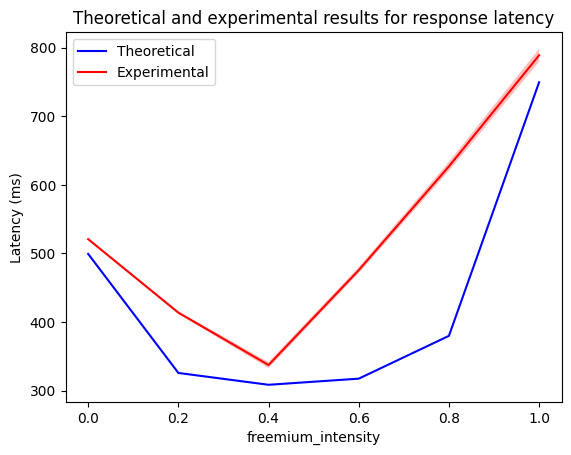

In [28]:

group_colums = [intensity_key]
averaged_columns = ["avg_latency_ms", "R0", *synth_cpu_cols, *cpu_columns]
avg_df = nb_helper.to_averaged_df(df, group_colums, averaged_columns)

nb_helper.create_figure(avg_df, intensity_key, "R0", "avg_latency_ms")

averaged_columns=['avg_latency_ms', 'R0', 'N_A', 'R0', 'N_B', 'Ut1_A', 'Ut2_A', 'Ut1_B', 'Ut2_B', 'Ut3_A', 'Ut3_B', 'cpu_utilization_s1a', 'cpu_utilization_s2a', 'cpu_utilization_s1b', 'cpu_utilization_s2b', 'cpu_utilization_s3', 'cpu_utilization_s4']


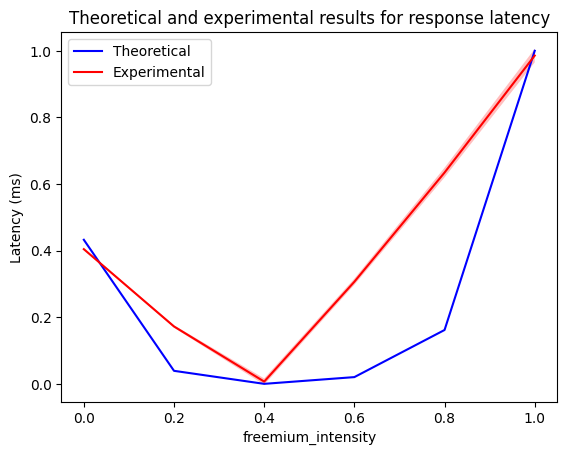

In [29]:
# Normalized data


def normalize(x, x_min, x_max):
    x -= x_min
    x /= x_max - x_min
    return x


df_norm = pd.DataFrame()
df_norm[intensity_key] = df[intensity_key]

r0_min, r0_max = min(df["R0"]), max(df["R0"])
df_norm["R0"] = df["R0"].transform(lambda x: normalize(x, r0_min, r0_max))

lat_min, lat_max = min(df["avg_latency_ms"]), max(df["avg_latency_ms"])
df_norm["avg_latency_ms"] = df["avg_latency_ms"].transform(
    lambda x: normalize(x, lat_min, lat_max)
)


avg_norm_df = nb_helper.to_averaged_df(df_norm, group_colums, averaged_columns)
nb_helper.create_figure(avg_norm_df, intensity_key, "R0", "avg_latency_ms")

## Evaluation


### Compares the delay data set using MAPE and Spearman's r


In [30]:
correlation_coefficient, p_value = spearmanr(df["R0"], df["avg_latency_ms"])

# Display the result
print("Spearman's correlation coefficient:")
sig = "significant" if p_value < 0.05 else "insignificant"
print(f"avg_latency_ms: {correlation_coefficient=:.3f} ({p_value=:.3f} ({sig}))")

Spearman's correlation coefficient:
avg_latency_ms: correlation_coefficient=0.876 (p_value=0.000 (significant))


### Mean average percentage error

Intuitively, how off the result is on average.

$\displaystyle M = \frac{1}{n}\sum^n_{t=1} \bigg|\frac{A_t - F_t}{A_t}\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [31]:

absolute_mape = stat_helper.mape(df["R0"], df["avg_latency_ms"])
eps = 1
normalized_mape = stat_helper.mape(df_norm["R0"] + eps, df_norm["avg_latency_ms"] + eps)

print(f"{absolute_mape=:.2f}, {normalized_mape=:.2f}% ({eps=})")

absolute_mape=18.59, normalized_mape=10.93% (eps=1)


### Mean absolute error

$\displaystyle M = \frac{1}{n}\sum^n_{t=1}\bigg|A_t - F_t\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [32]:
def mae(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele))
    m /= len(expected)
    return m


absolute_mae = mae(df["R0"], df["avg_latency_ms"])
normalized_mae = 100 * mae(df_norm["R0"], df_norm["avg_latency_ms"])

print(f"{absolute_mae=:.3f}, {normalized_mae=:.2f}%")

absolute_mae=97.147, normalized_mae=15.69%


# Visualizing the relationship

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


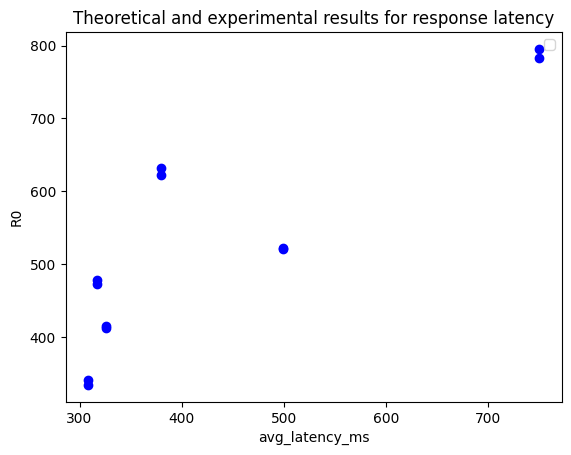

In [33]:
# Create a figure and axis
plt.figure()
ax = plt.axes()

# Plot the first line (sine function)
ax.scatter(df["R0"], df["avg_latency_ms"], color="blue")

# Add labels and a legend
ax.set_ylabel("R0")
ax.set_xlabel("avg_latency_ms")
ax.set_title("Theoretical and experimental results for response latency")
ax.legend()

# Show the plot
plt.show()

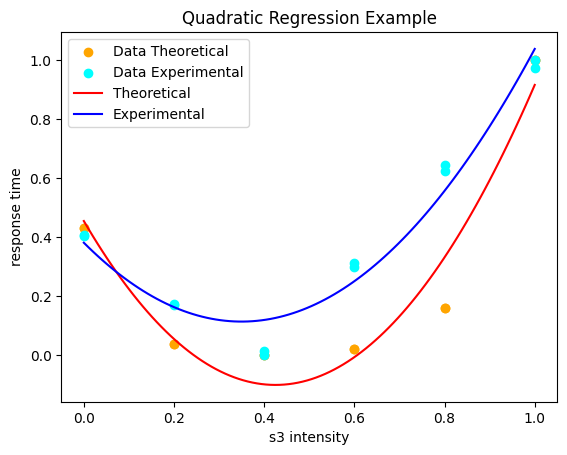

In [34]:
import numpy as np
import matplotlib.pyplot as plt


def normalize_field(df: pd.DataFrame, field: str) -> pd.DataFrame:
    min_x, max_x = min(df[field]), max(df[field])
    df.loc[:, field] = df[field].transform(lambda x: normalize(x, min_x, max_x))
    return df

test_df = df.copy()
test_df = normalize_field(test_df, "R0")
test_df = normalize_field(test_df, "avg_latency_ms")

test_df


def make_model(x, y):
    # Fit a quadratic regression model
    coefficients = np.polyfit(x, y, 2)
    quadratic_model = np.poly1d(coefficients)

    # Generate y values from the model for smooth plotting
    x_smooth = np.linspace(min(x), max(x), 100)
    y_smooth = quadratic_model(x_smooth)
    return x_smooth, y_smooth


# Sample data
# x = np.array([1, 2, 3, 4, 5])
# y = np.array([3, 8, 12, 8, 3])
x = test_df[intensity_key].tolist()
y = test_df["R0"].tolist()
x_smooth, y_smooth = make_model(x, y)

y2 = test_df["avg_latency_ms"].tolist()
x2_smooth, y2_smooth = make_model(x, y2)

# Plot the data and the quadratic regression curve
plt.scatter(x, y, label='Data Theoretical', color='orange')
plt.scatter(x, y2, label='Data Experimental', color='cyan')
plt.plot(x_smooth, y_smooth, color="red", label="Theoretical")
plt.plot(x2_smooth, y2_smooth, color="blue", label="Experimental")
plt.xlabel('s3 intensity')
plt.ylabel("response time")
plt.title("Quadratic Regression Example")
plt.legend()
plt.show()

# CPU Utilization

## Visualization

averaged_columns=['avg_latency_ms', 'R0', 'N_A', 'R0', 'N_B', 'Ut1_A', 'Ut2_A', 'Ut1_B', 'Ut2_B', 'Ut3_A', 'Ut3_B', 'cpu_utilization_s1a', 'cpu_utilization_s2a', 'cpu_utilization_s1b', 'cpu_utilization_s2b', 'cpu_utilization_s3', 'cpu_utilization_s4']


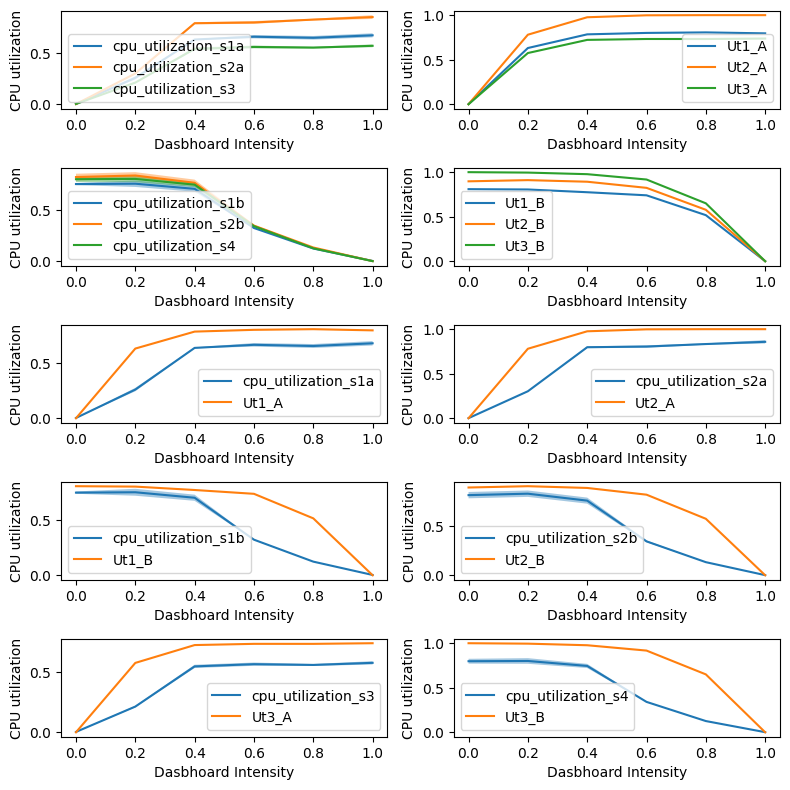

In [35]:
comparison_tuples = [
    (
        "cpu_utilization_s1a",
        "cpu_utilization_s2a",
        "cpu_utilization_s3",
    ),
    (
        "Ut1_A",
        "Ut2_A",
        "Ut3_A",
    ),
    (
        "cpu_utilization_s1b",
        "cpu_utilization_s2b",
        "cpu_utilization_s4",
    ),
    ("Ut1_B", "Ut2_B", "Ut3_B"),
    ("cpu_utilization_s1a", "Ut1_A"),
    ("cpu_utilization_s2a", "Ut2_A"),
    ("cpu_utilization_s1b", "Ut1_B"),
    ("cpu_utilization_s2b", "Ut2_B"),
    ("cpu_utilization_s3", "Ut3_A"),
    ("cpu_utilization_s4", "Ut3_B"),
]
avg_df = nb_helper.to_averaged_df(df, group_colums, averaged_columns)
nb_helper.create_plot_comparisons(comparison_tuples, avg_df, intensity_key)

averaged_columns=['avg_latency_ms', 'R0', 'N_A', 'R0', 'N_B', 'Ut1_A', 'Ut2_A', 'Ut1_B', 'Ut2_B', 'Ut3_A', 'Ut3_B', 'cpu_utilization_s1a', 'cpu_utilization_s2a', 'cpu_utilization_s1b', 'cpu_utilization_s2b', 'cpu_utilization_s3', 'cpu_utilization_s4']


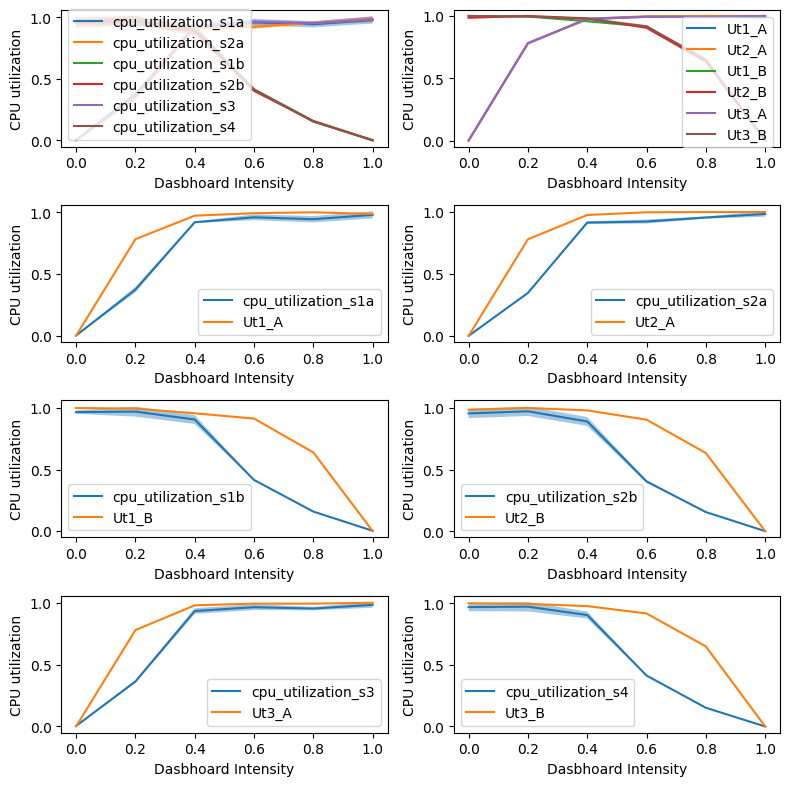

In [36]:
norm_df = pd.DataFrame()

for col in df.select_dtypes(include="number").columns:
    min_x, max_x = min(df[col]), max(df[col])
    norm_df[col] = df[col].transform(lambda x: normalize(x, min_x, max_x))

comparison_tuples = [
    (
        "cpu_utilization_s1a",
        "cpu_utilization_s2a",
        "cpu_utilization_s1b",
        "cpu_utilization_s2b",
        "cpu_utilization_s3",
        "cpu_utilization_s4",
    ),
    ("Ut1_A", "Ut2_A", "Ut1_B", "Ut2_B", "Ut3_A", "Ut3_B"),
    ("cpu_utilization_s1a", "Ut1_A"),
    ("cpu_utilization_s2a", "Ut2_A"),
    ("cpu_utilization_s1b", "Ut1_B"),
    ("cpu_utilization_s2b", "Ut2_B"),
    ("cpu_utilization_s3", "Ut3_A"),
    ("cpu_utilization_s4", "Ut3_B"),
]
avg_norm_df = nb_helper.to_averaged_df(norm_df, group_colums, averaged_columns)
nb_helper.create_plot_comparisons(comparison_tuples, avg_norm_df, intensity_key)

## Evaluation

In [37]:
comparison_tuples = [
    ("cpu_utilization_s1a", "Ut1_A"),
    ("cpu_utilization_s2a", "Ut2_A"),
    ("cpu_utilization_s1b", "Ut1_B"),
    ("cpu_utilization_s2b", "Ut2_B"),
    ("cpu_utilization_s3", "Ut3_A"),
    ("cpu_utilization_s4", "Ut3_B"),
]

### Spearman's correlation coefficient

In [38]:
print("Spearman's correlation coefficient:")
for real, expected in comparison_tuples:
    correlation_coefficient, p_value = spearmanr(df[expected], df[real])

    # Display the result
    sig = "significant" if p_value < 0.05 else "insignificant"
    print(f"{real}: {correlation_coefficient:.3f} ({p_value=:.3f} {sig})")

Spearman's correlation coefficient:
cpu_utilization_s1a: 0.820 (p_value=0.001 significant)
cpu_utilization_s2a: 0.919 (p_value=0.000 significant)
cpu_utilization_s1b: 0.961 (p_value=0.000 significant)
cpu_utilization_s2b: 0.975 (p_value=0.000 significant)
cpu_utilization_s3: 0.919 (p_value=0.000 significant)
cpu_utilization_s4: 0.961 (p_value=0.000 significant)


### Mean average (percentage) error

In [39]:
for real, expected in comparison_tuples:
    mape_score = stat_helper.mape(df[expected], df[real])
    mae_score = mae(df[expected], df[real])
    print(f"{real}: {mape_score=:.2f}%, {mae_score=:.3f}")

    eps = 1
    norm_mape_score = stat_helper.mape(norm_df[expected] + eps, norm_df[real] + eps)
    norm_mae_score = 100 * mae(norm_df[expected], norm_df[real])
    print(f"{real}: {norm_mape_score=:.2f}% ({eps=}), {norm_mae_score=:.2f}%\n")

cpu_utilization_s1a: mape_score=54.62%, mae_score=0.154
cpu_utilization_s1a: norm_mape_score=6.40% (eps=1), norm_mae_score=9.56%

cpu_utilization_s2a: mape_score=56.80%, mae_score=0.193
cpu_utilization_s2a: norm_mape_score=7.05% (eps=1), norm_mae_score=10.49%

cpu_utilization_s1b: mape_score=95.29%, mae_score=0.165
cpu_utilization_s1b: norm_mape_score=13.80% (eps=1), norm_mae_score=18.24%

cpu_utilization_s2b: mape_score=100.93%, mae_score=0.201
cpu_utilization_s2b: norm_mape_score=14.15% (eps=1), norm_mae_score=18.78%

cpu_utilization_s3: mape_score=65.35%, mae_score=0.174
cpu_utilization_s3: norm_mape_score=6.27% (eps=1), norm_mae_score=9.18%

cpu_utilization_s4: mape_score=127.72%, mae_score=0.288
cpu_utilization_s4: norm_mape_score=14.28% (eps=1), norm_mae_score=18.88%

